In [1]:
import sys, os
from pathlib import Path
ROOT = Path.cwd().parent
if str(ROOT / 'src') not in sys.path:
    sys.path.insert(0, str(ROOT / 'src'))
print('Added to sys.path:', ROOT / 'src')


Added to sys.path: /home/spina/Desktop/units/DL/project/mice-representation-clean/src


In [2]:

import os, sys, math, json
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path


sys.path.append('../..')


from pipeline.mouse_transforms import mouse_transform

from pipeline.mouse_transforms import UnNormalize
from pipeline.mouse_csf import load_or_fit_params
from pipeline.plot_utils import *

IMAGE_PATH = ROOT / 'assets/ant.png'  
# IMAGE_PATH = ROOT / 'assets/dog.JPEG'  
CSF_JSON = ROOT / 'artifacts/mouse_csf_params.json'
os.makedirs(os.path.dirname(CSF_JSON), exist_ok=True)


import random, numpy as np, torch
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
if torch.backends.cudnn.is_available():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


CSF_FIT = False

IMG_SIZE = 224

In [3]:
blur_sig, blur_ker, noise_std, patch_size = load_or_fit_params(CSF_JSON, force_fit=CSF_FIT, pca_n=32)
print(f'CSF params: blur_sigma={blur_sig:.3f}, blur_ker={blur_ker}, noise_std={noise_std:.3f}, patch_size={patch_size}')

Loading cached CSF params from /home/spina/Desktop/units/DL/project/mice-representation-clean/artifacts/mouse_csf_params.json
CSF params: blur_sigma=1.760, blur_ker=29, noise_std=0.250, patch_size=24


In [4]:
noise_rng = torch.Generator().manual_seed(1)

tfm = mouse_transform(
    img_size=224,
    blur_sig=blur_sig,
    noise_std=noise_std,
    normalize='imagenet',
    noise_rng=noise_rng,
    to_gray=True,
    gray_keep_channels=True,
)

unnorm = UnNormalize('imagenet')

In [5]:
assert os.path.isfile(IMAGE_PATH), f'Image not found: {IMAGE_PATH}'

# The pipeline returns a dict after the affine step; extract the tensor
def _get_img_t(out):
    if isinstance(out, dict):
        img_t = out['imgs']
        affine_params = out.get('affine', None)  # (angle, translations, scale, shear)
    else:
        img_t = out
        affine_params = None
    disp = unnorm(out if isinstance(out, dict) else img_t)
    disp_t = disp['imgs'] if isinstance(disp, dict) else disp
    disp_t = disp_t.detach().cpu().clamp(0, 1)
    disp_t = disp_t[0] if disp_t.dim() == 4 else disp_t
    disp_np = disp_t.permute(1, 2, 0).numpy()
    return disp_np, affine_params

In [6]:
img_pil = Image.open(IMAGE_PATH).convert('RGB')

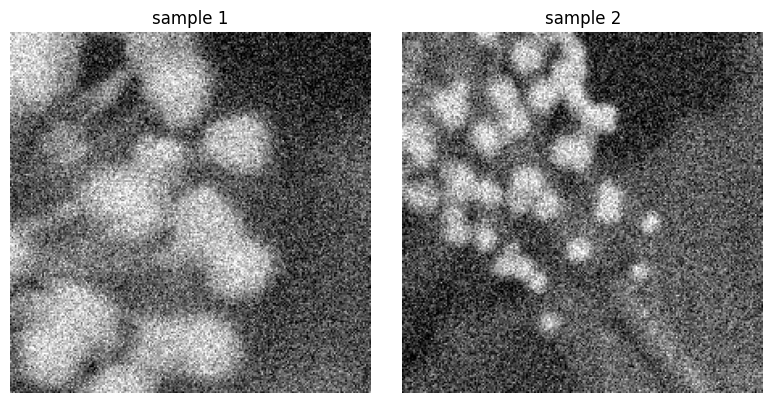

In [7]:
from pipeline.plot_utils import plot_image_pair

plot_image_pair(_get_img_t(tfm(img_pil))[0], _get_img_t(tfm(img_pil))[0], title_left='sample 1', title_right='sample 2')
pass

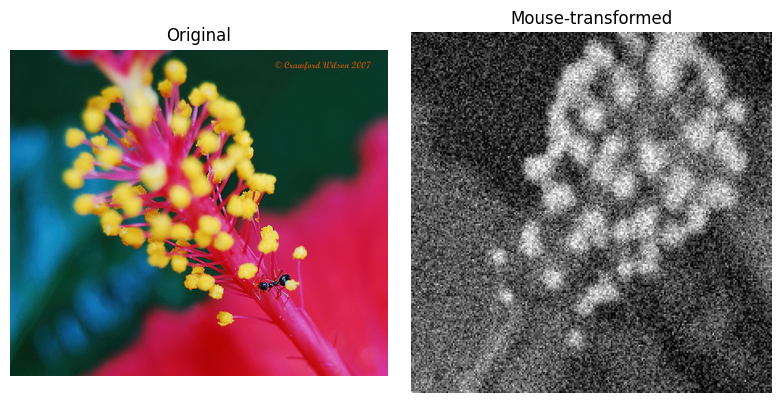

In [8]:
disp_np, _ = _get_img_t(tfm(img_pil))
plot_image_pair(img_pil, disp_np, title_left='Original', title_right='Mouse-transformed')
pass

Done. Computed psychometric curves and thresholds for 6 spatial frequencies.


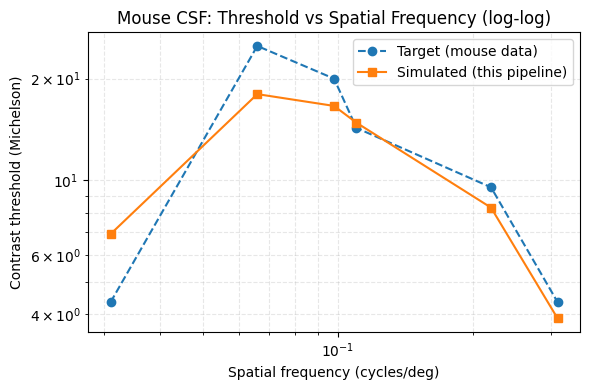

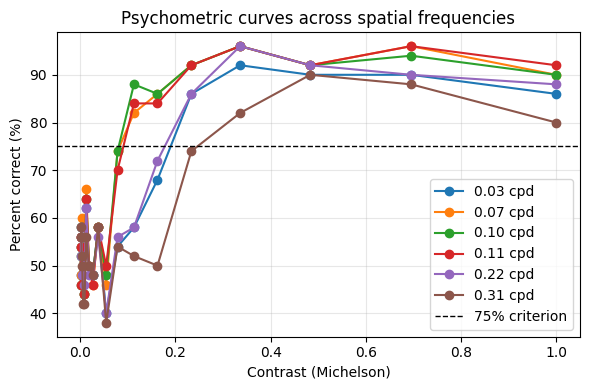

In [9]:
# Cell — Imports for CSF plotting
import numpy as np
import matplotlib.pyplot as plt

from pipeline.mouse_params import MOUSE_CSF_TARGET, CONTRAST_SWEEP, THRESH_CRITERION
from pipeline.mouse_csf import _simulate_detection, _estimate_threshold
import pipeline.mouse_csf as mouse_csf  

mouse_csf.N_SAMPLES_PER_CLASS = 5000  


SIM_IMG_SIZE = 224
size = (SIM_IMG_SIZE, SIM_IMG_SIZE)


SF_LIST = sorted(MOUSE_CSF_TARGET.keys())
curves = {}         # sf -> (contrasts, acc)
thresholds = {}     # sf -> threshold

for sf in SF_LIST:
    contrasts, acc = _simulate_detection(
        size, sf, blur_sig, blur_ker, noise_std,
        CONTRAST_SWEEP,
        patch_size=patch_size,
        seed=112, deterministic=True,
    )

    thr = _estimate_threshold(contrasts, acc, THRESH_CRITERION)
    curves[sf] = (contrasts, acc)
    thresholds[sf] = thr

print('Done. Computed psychometric curves and thresholds for', len(SF_LIST), 'spatial frequencies.')
from pipeline.plot_utils import plot_csf_thresholds, plot_psychometric_curves
    
plot_csf_thresholds(SF_LIST, thresholds, MOUSE_CSF_TARGET)

# Psychometric curves
SFS_TO_PLOT = list(curves.keys())
plot_psychometric_curves(curves, SFS_TO_PLOT, threshold_criterion=THRESH_CRITERION)

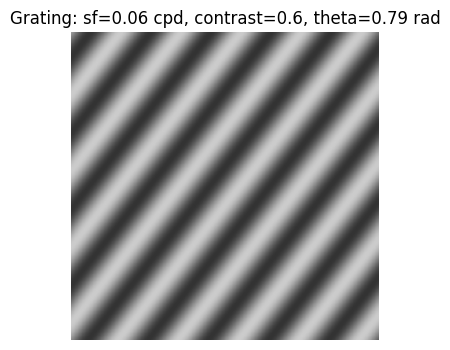

In [10]:
# Example grating using _make_grating
import sys, math
import torch
import matplotlib.pyplot as plt

# Ensure project src is importable
sys.path.append('/home/gamerio/Documents/dl/mice-representation/src')

from pipeline.mouse_csf import _make_grating  # private helper used by CSF code

# Parameters
img_size = 224

sf_cpd   = 0.06
     # spatial frequency (cycles/deg), e.g., 0.06, 0.16, 0.33
contrast = 0.6      # Michelson contrast in [0,1]
phase    = 0.0      # radians
theta    = math.pi/4  # orientation in radians (e.g., 0, pi/4, pi/2)

# Generate and display
g = _make_grating((img_size, img_size), sf_cpd, contrast, phase, theta)  # HxW tensor in [0,1]
from pipeline.plot_utils import plot_grating
plot_grating(g, title=f'Grating: sf={sf_cpd} cpd, contrast={contrast}, theta={theta:.2f} rad')